# GenFL - Personalized Scenario (non i.i.d) - Posterior from learnt Prior

This notebook shows an example of how to reproduce some results from the paper `Federated Learning with Nonvacuous Generalisation Bounds`.
Specifically the ones about personalized scenario.

Abstract

We introduce a novel strategy to train randomised predictors in federated learning, where each node of the network aims at preserving its privacy by releasing a local predictor but keeping secret its training dataset with respect to the other nodes. We then build a global randomised predictor which inherits the properties of the local private predictors in the sense of a PAC-Bayesian generalisation bound. We consider the synchronous case where all nodes share the same training objective (derived from a generalisation bound), and the asynchronous case where each node may have its own personalised training objective. We show through a series of numerical experiments that our approach achieves a comparable predictive performance to that of the batch approach where all datasets are shared across nodes. More over the predictors are supported by numerically nonvacuous generalisation bounds while preserving privacy for each node. We explicitly compute the increment on predictive performance and generalisation bounds between batch and federated settings, highlighting the price to pay to preserve privacy

# Startup

The code is meant to be used as a bash CLI. For pedagogic reasons, let's see it through a notebook file.

In [ ]:
%cd ..

## Building a Prior

As in the prior network, we will produce a prior with a config file in `./conf/scenario/personalized_prior.yaml` using the default configuration `./conf/genfl_personalized.yaml`.

There are some differences with other config files:
- `partition_type` is different, we are in a non-i.i.d case !
- `perc_train`, `perc_val`, `perc_test` are all used in this configuration. `perc_test` is used to build a local dataset in order to verify the local model (because there is no more global model in the posterior personalization step)
- there is `objective` key to prevent using other config file with `GenFL_personalized.py` and in addition it guides its behavior.

Let's build a prior:

In [ ]:
%%bash

python GenFL_personalized.py +scenario=personalizd_prior

# Example: `accuracy_Metrics_tmp.png`

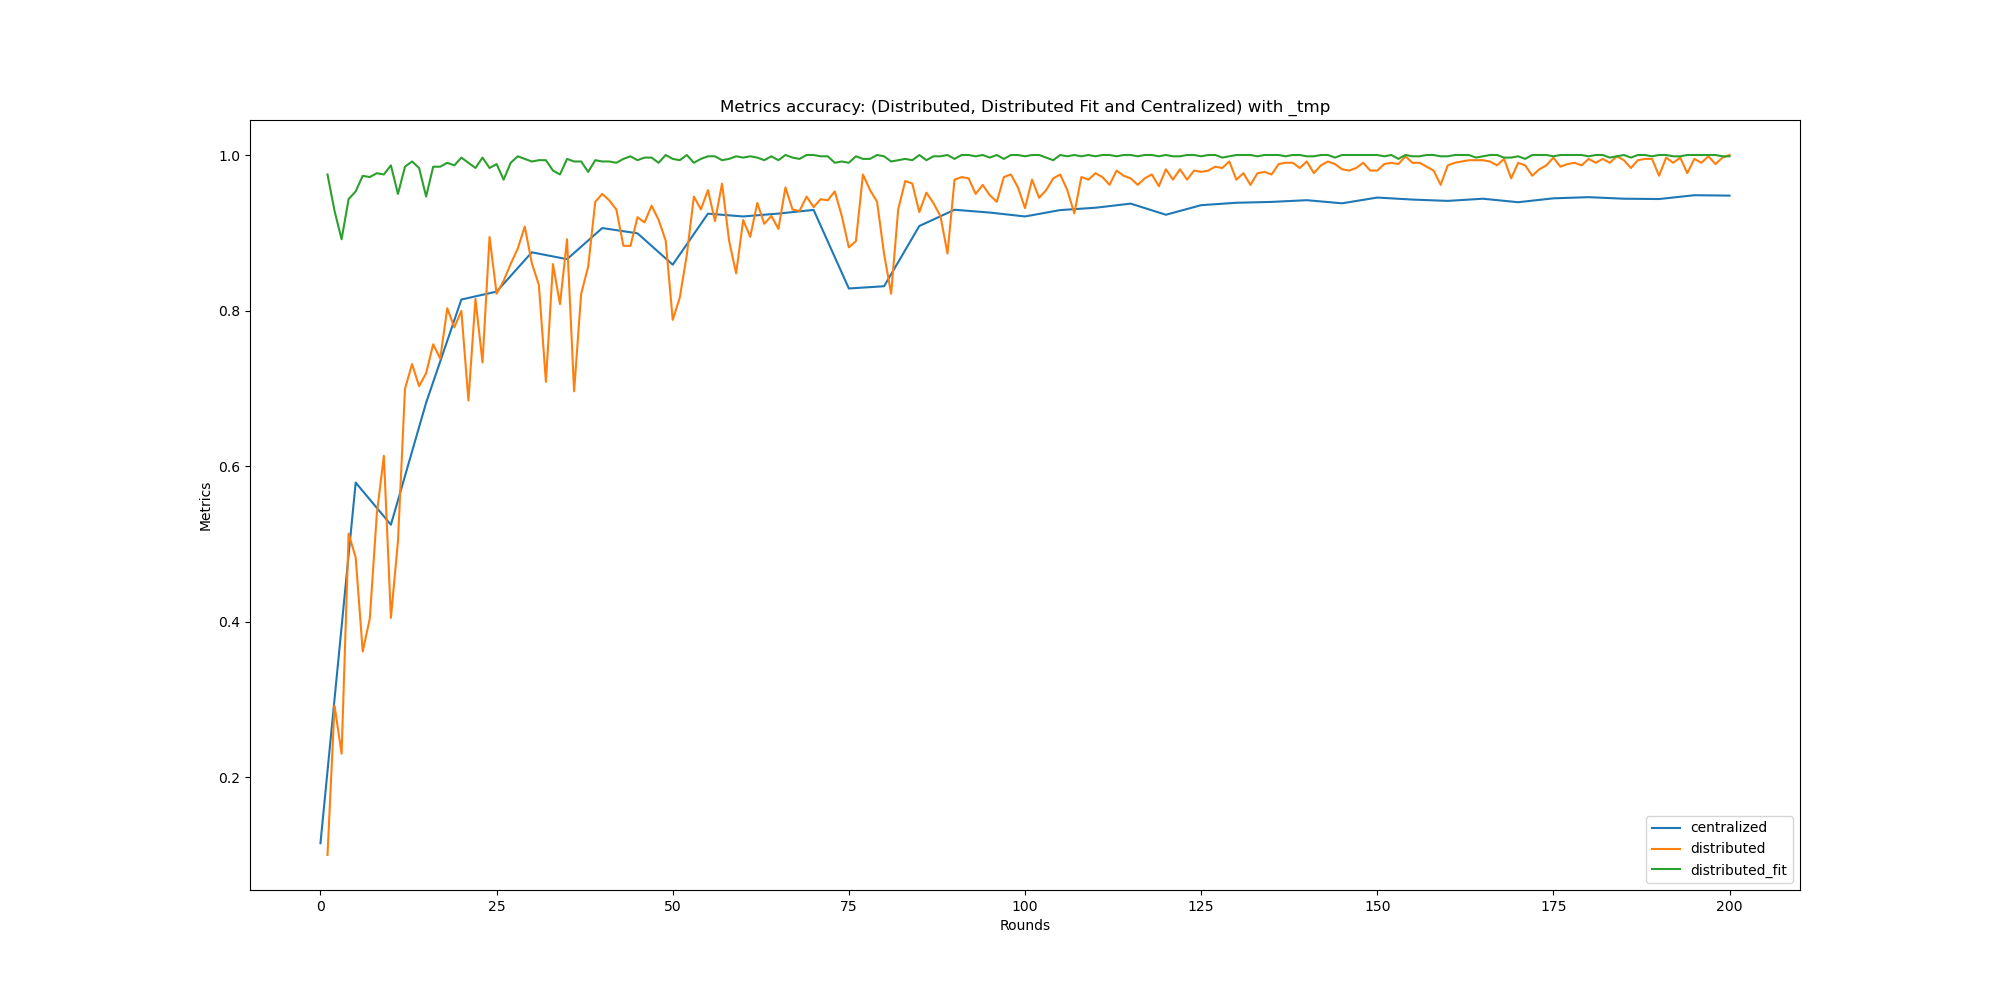

The accuracy is increasing slower than in the first notebook. This is normal, the data distribution is not the same: i.i.d vs. non-i.i.d. The accuracy on the test set (centralized curve) of MNIST is also deteriorated.

We've build a prior, we can now train a posterior from this prior.

## Building Personalized Posteriors

Now, let's build personalized (local) posteriors. This step, will build `num_clients` posteriors, each for one client. We will not aggregate these models because the PAC-Bayes objective is local. There is not the i.i.d condition which allow us to use all the data points as in GenFL FL-SOB scenario.

For safety reason, there is `dryrun=True` (debug feature: almost all loops once), remove it to get correct computation.  
The results are not the ones from the paper, for it, you need `pbobj.mc_samples=150000`. BE CAREFUL, it takes several hours to days to compute. 

In [ ]:
%%bash

python GenFL_personalized.py \
    +scenario=personalizd_posterior \
    resume_checkpoint_prior='path_to_code/outputs/GenFL_Personalized/[Date]/[Time]/+scenario\=personalized_prior' \
    dryrun=True

All the figures in the directory `path_to_saved_directory/metrics` are not easily readable, because there is only a single point.  
However, there is `path_to_saved_directory/checkpoint_round_all_clients_metrics_1.pth` which contains all the metrics from all the clients, just before aggregation. These un-aggregated metrics were used to produce the histograms in our paper.

In the next cell, we propose to build one histogram based on these client metrics. If you ran with high enough `pbobj.mc_samples`, you can uncomment the code, to add the generalisation bound of each clients in the histogram.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from omegaconf import OmegaConf
# from omegaconf import open_dict

import torch

# from core import bounds

path = "[path_to_code]/GenFL_Personalized/[Date]/[Time]/+scenario=personalized_prior" # TODO: change [path_to_code], [Date], [Time]

all_metrics = torch.load(path + "/checkpoint_round_all_clients_metrics_1.pth")
cfg_path = path + "/.hydra/config.yaml"
cfg = OmegaConf.load(cfg_path)
assert cfg.objective == "personalized"

all_01 = [(num_examples, metrics["accuracy_stch"]) for (num_examples, metrics) in list(all_metrics.values())]
error_stch_c = [1.-metrics["accuracy_stch"] for (_, metrics) in list(all_metrics.values())]
# error_ce_c = [metrics["error_ce"] for (_, metrics) in list(all_metrics.values())]
error_01_c = [metrics["error_01"] for (_, metrics) in list(all_metrics.values())]

# local_train_size = [num_examples for (num_examples, _) in list(all_metrics.values())][0] # all values should be the same
# kl_c = [metrics["kl_n_c"]*num_examples for (num_examples, metrics) in list(all_metrics.values())]
# with open_dict(cfg):
#     cfg.pbobj.n_bound = local_train_size
#     cfg.pbobj.n_posterior = local_train_size

# risk_01_c = np.array([
#     bounds.compute_final_stats_risk_server(error_ce_c[i], error_01_c[i], cfg, torch.tensor(kl_c[i]))[5] for i in range(len(error_ce_c))
# ])

plt.figure(figsize=(10, 10))
maxi = np.max(error_stch_c)
# maxi = max(np.max(risk_01_c), np.max(error_stch_c))
mybins = np.arange(0, maxi, maxi/20.)
plt.hist(error_stch_c, bins=mybins, label="Test error", edgecolor="black", alpha=0.5, color="red")
# plt.hist(risk_01_c, bins=mybins, label="Gen. Bound", edgecolor="black", alpha=0.5, color="blue")
plt.ylabel("Number of clients")
plt.xlabel("(Local) 0-1 error"
          #  "/0-1 risk"
)
plt.axvline(np.mean(error_stch_c), color='red', linestyle='dashed', linewidth=1.5, label="Mean Test error")
# plt.axvline(np.mean(risk_01_c), color='blue', linestyle='dashed', linewidth=1.5, label="Mean Gen. Bound")
error_01_array = np.array([1.-metrics["accuracy_stch"] for (_, metrics) in list(all_metrics.values())])
plt.legend(fontsize=20)
plt.title(f"######## {cfg.pbobj.objective}, {cfg.objective}, {cfg.prior_type} ######## \n"
          f"Personalized Scenario : Histogram of {cfg.num_clients} clients: \n"
          f"0-1 Loss: min={np.min(error_01_array):.3f}, mean={np.mean(error_01_array):.3f}, max={np.max(error_01_array):.3f}"
        #   f"0-1 Risk: min={np.min(risk_01_c):.3f}, mean={np.mean(risk_01_c):.3f}, max={np.max(risk_01_c):.3f}"
)
plt.show()

Running this cell above would give a histogram like this:

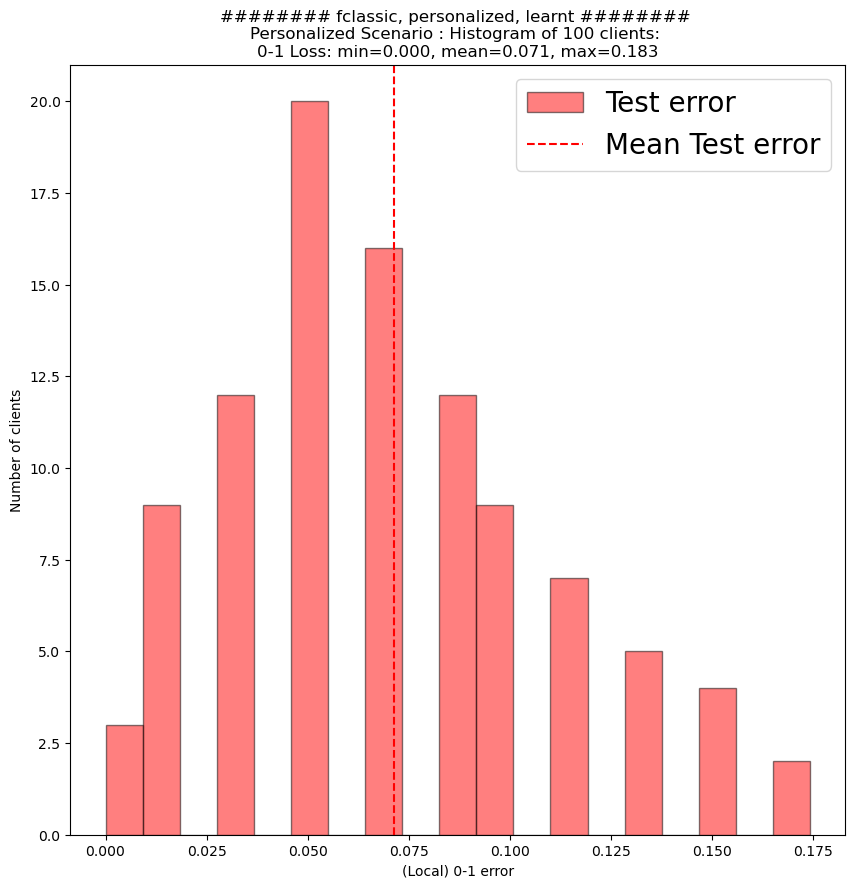